In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, activations
from tensorflow.keras.layers import Conv2D, TimeDistributed, BatchNormalization, MaxPooling2D, Flatten, Bidirectional, Dense,Dropout,Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
x_data = np.load('face_x_data.npy') # x_save.npy
y_data = np.load('face_y_data.npy') # y_data.npy
y_data = keras.utils.to_categorical(y_data,11)
print(x_data.shape, y_data.shape)

(3000, 27, 64, 64, 3) (3000, 11)


In [46]:
print(y_data[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [47]:
# Train과 Test 분리
X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size = 0.2, shuffle = True, stratify=y_data)
print("x_train: {}, X_test: {}".format(X_train.shape, X_test.shape))
print("Y_train: {}, Y_test: {}".format(Y_train.shape, Y_test.shape))

x_train: (2400, 27, 64, 64, 3), X_test: (600, 27, 64, 64, 3)
Y_train: (2400, 11), Y_test: (600, 11)


In [48]:
class VGG_LSTM_fine(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(VGG_LSTM_fine, self).__init__()
        self.BZ = input_shape[0]
        self.frame = input_shape[1]

        self.vgg = VGG16(weights='imagenet', include_top=False,
                         input_shape=(input_shape[2], input_shape[3], input_shape[4]))
        self.vgg.trainable = False

        set_trainable = False
        for layer in self.vgg.layers:
            if layer.name == 'block5_conv1' or layer.name == 'block5_conv2' or layer.name == 'block5_conv3' or layer.name == 'block5_pool':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
        self.vggDistributed = TimeDistributed(self.vgg)        
        self.bilstm = layers.Bidirectional(layers.LSTM(256), merge_mode='concat')
        self.dense = layers.Dense(num_classes, activation='softmax')
        self.max_pool = layers.MaxPooling2D(pool_size=(2, 2))
        self.dropout = layers.Dropout(0.2)
        self.flat= TimeDistributed(Flatten())
        
    def call(self, x):
        x = self.vggDistributed(x)
        x = self.flat(x)
        x = self.dropout(x)
        x = self.bilstm(x)
        x = self.dense(x)
        return x

In [49]:
def get_model_vgg_fine():
    return VGG_LSTM_fine(input_shape = (10, 68, 64, 64, 3), num_classes = 11)

In [50]:
tf.config.experimental_run_functions_eagerly(True)

In [51]:
model = get_model_vgg_fine()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience = 10)
history = model.fit(X_train, Y_train, batch_size=16, epochs=100, verbose = 1, validation_data = (X_test, Y_test), callbacks = [es])

/Users/heegeepark/venv/myvenv/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/100
150/150 [==============================] - 3413s 23s/step - loss: 2.4442 - accuracy: 0.0808 - val_loss: 2.2914 - val_accuracy: 0.1100
Epoch 2/100
150/150 [==============================] - 7951s 53s/step - loss: 2.2808 - accuracy: 0.1343 - val_loss: 2.2989 - val_accuracy: 0.1400
Epoch 3/100
150/150 [==============================] - 3109s 21s/step - loss: 2.2103 - accuracy: 0.1987 - val_loss: 2.2719 - val_accuracy: 0.1717
Epoch 4/100
150/150 [==============================] - 3114s 21s/step - loss: 2.1466 - accuracy: 0.2379 - val_loss: 2.1972 - val_accuracy: 0.2100
Epoch 5/100
150/150 [==============================] - 3100s 21s/step - loss: 2.0441 - accuracy: 0.2901 - val_loss: 2.1670 - val_accuracy: 0.1967
Epoch 6/100
150/150 [==============================] - 3100s 21s/step - loss: 1.9341 - accuracy: 0.3332 - val_loss: 2.1082 - val_accuracy: 0.2383
Epoch 7/100
150/150 [==============================] - 3097s 21s/step - loss: 1.7941 - accuracy: 0.3836 - val_loss: 2.0672 -

In [52]:
history.history

{'loss': [2.3688571453094482,
  2.273064374923706,
  2.215923547744751,
  2.1394145488739014,
  2.049741506576538,
  1.9311987161636353,
  1.7999680042266846,
  1.6552917957305908,
  1.4971286058425903,
  1.3905487060546875,
  1.2585030794143677,
  1.1513190269470215,
  1.0488091707229614,
  0.9625027179718018,
  0.8495316505432129,
  0.7531171441078186,
  0.6612324118614197,
  0.5595611333847046,
  0.5347036719322205,
  0.42729252576828003,
  0.35507750511169434,
  0.34349778294563293,
  0.2950856387615204,
  0.2741045653820038,
  0.27944397926330566,
  0.2313668578863144,
  0.1842891126871109,
  0.17431306838989258,
  0.16473960876464844,
  0.17105630040168762,
  0.1406058818101883],
 'accuracy': [0.09000000357627869,
  0.14249999821186066,
  0.18541666865348816,
  0.23250000178813934,
  0.2704166769981384,
  0.3283333480358124,
  0.3816666603088379,
  0.4362500011920929,
  0.49416667222976685,
  0.5274999737739563,
  0.5924999713897705,
  0.6245833039283752,
  0.6575000286102295,
  

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


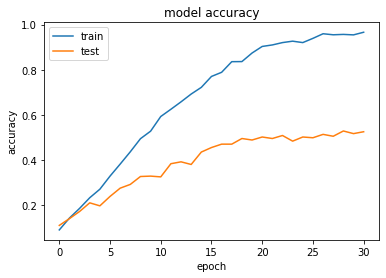

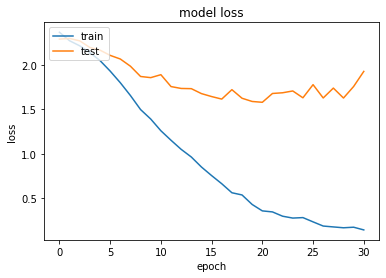

In [53]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()